# Plot the KP turbine wakes (hub-height)

In [1]:
# Load the amrwind-frontend module
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['../',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Important header information                                                                                                                                               
import postprolib as pp
# Load the libraries                                                                                                                                                         
import postproamrwindsample as ppsample
import numpy             as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import xarray as xr
import pickle
import pandas as pd

# Make all plots inline 
%matplotlib inline

In [2]:
extractvar = lambda xrds, var, i : xrds[var][i,:].data.reshape(tuple(xrds.attrs['ijk_dims'][::-1]))

def loadPickle(picklefname):
    pfile = open(picklefname, 'rb')
    db   = pickle.load(pfile)
    x    = db['x']
    y    = db['y']
    z    = db['z']
    vx   = db['vx']
    vy   = db['vy']
    vz   = db['vz']
    time = db['time']
    pfile.close()
    return x, y, z, vx, vy, vz, time

def avgfield(v, mintime, maxtime):
    avgv = None
    iavg = 0
    for itime, vfield in v.items():
        if (mintime<=itime) and (itime<=maxtime):
            iavg += 1
            if avgv is None:
                avgv = vfield
            else:
                avgv += vfield
    #print(iavg)
    return avgv/float(iavg)

def makecbarax(ax, c, fontsize, size='5%'):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=0.05)
    cbar=fig.colorbar(c, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=fontsize)

def setfigtextsize(ax, fsize):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.yaxis.get_offset_text()] + ax.get_xticklabels() + ax.get_yticklabels() ):
        item.set_fontsize(fsize)

In [3]:
def getTurbSubset(csvfile, suffix):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        if x[1]['# name'].endswith(suffix):
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

def getTurbSubsetXY(csvfile, suffix, xlim=[-np.finfo(np.float64).max, np.finfo(np.float64).max], ylim=[-np.finfo(np.float64).max, np.finfo(np.float64).max]):
    # Load the data from the database of all turbines
    allturbsdf = pd.read_csv(csvfile, low_memory=False)
    # Get just the King Plains turbines
    subset = [] 
    for x in allturbsdf.iterrows():
        xy = [float(x[1][' x']), float(x[1][' y'])]
        if x[1]['# name'].endswith(suffix) and ((xlim[0] <= xy[0]) and (xy[0]<=xlim[1]) and (ylim[0]<=xy[1]) and (xy[1]<=ylim[1])):
            #print(x[1])
            subset.append(x[1])
    subsetdf = pd.DataFrame(subset[:])
    return subsetdf

getturbnames = lambda df: [x[1]['# name'] for x in df.iterrows()]

def getCartesianMesh(x,y):
    p00=np.array([x[0,0], y[0,0]])
    p10=np.array([x[1,0], y[1,0]])
    p01=np.array([x[0,1], y[0,1]])
    dx=np.linalg.norm(p00-p10)
    dy=np.linalg.norm(p00-p01)
    hhshape=x.shape
    xvec=np.arange(hhshape[0])*dx
    yvec=np.arange(hhshape[1])*dy
    xm, ym = np.meshgrid(xvec, yvec)
    return xm.transpose(), ym.transpose()

def avgFileList(turblist, tavg1, tavg2):
    avgvx = None
    avgvy = None
    avgvz = None
    for turb in turblist:
        x, y, z, vx, vy, vz, time = loadPickle(turb)
        vx_avg = avgfield(vx, tavg1, tavg2)
        vy_avg = avgfield(vy, tavg1, tavg2)
        vz_avg = avgfield(vz, tavg1, tavg2)
        if avgvx is None:
            avgvx = vx_avg
            avgvy = vy_avg
            avgvz = vz_avg
        else:
            avgvx += vx_avg
            avgvy += vy_avg
            avgvz += vz_avg
    N = len(turblist)
    return x, y, z, avgvx/N, avgvy/N, avgvz/N

In [4]:
summitcsv    = '../UnstableABL_farmrun_turbines.csv'
pkldir       = 'means/KPturbshh/'
turbname     = '%s_hh_mean_%s.pkl'
tavg1 = 300
tavg2 = 999

In [5]:
allturblist = getturbnames(getTurbSubset(summitcsv, '-KP'))

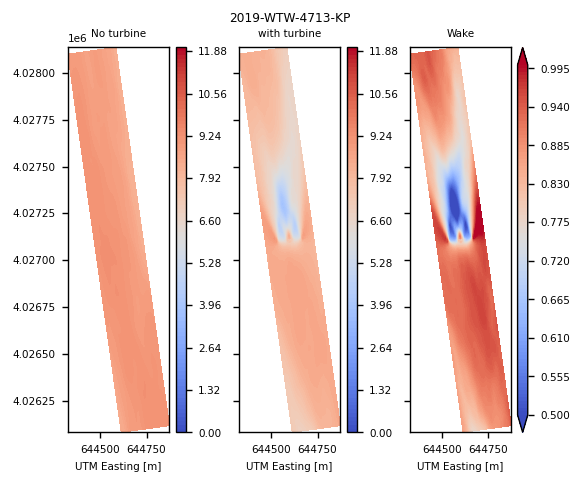

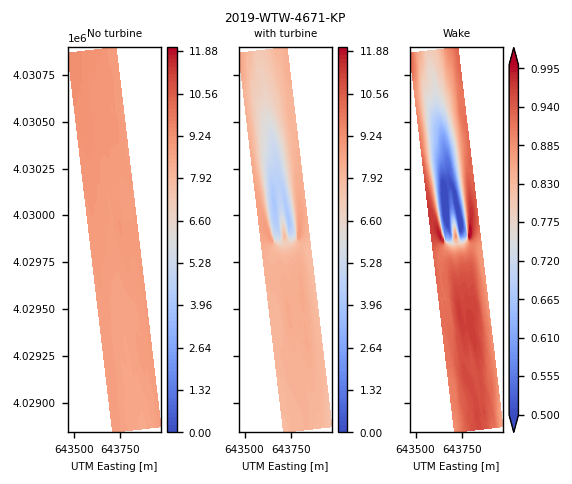

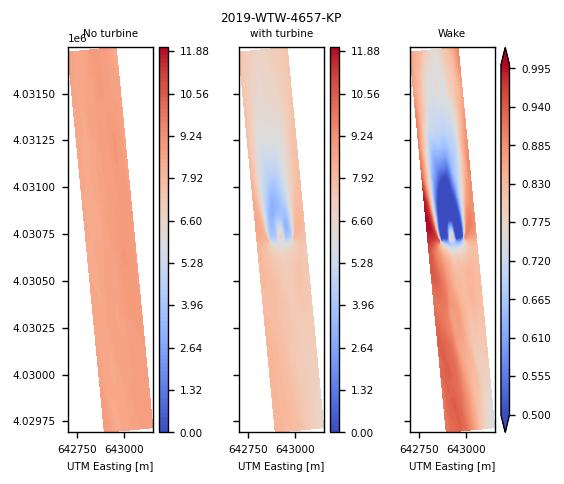

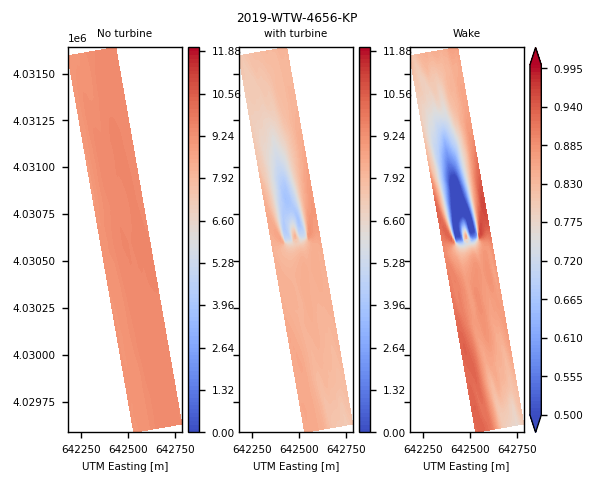

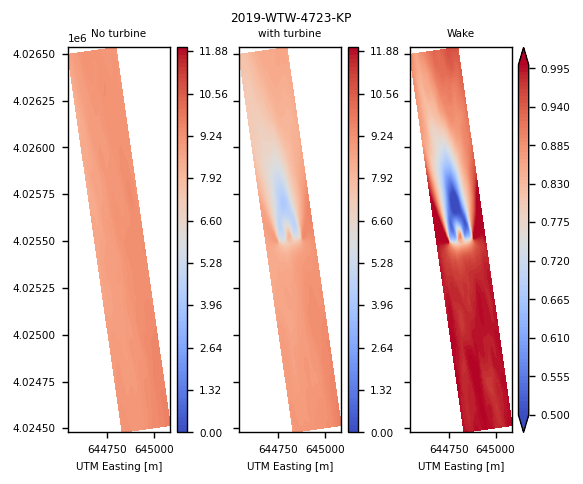

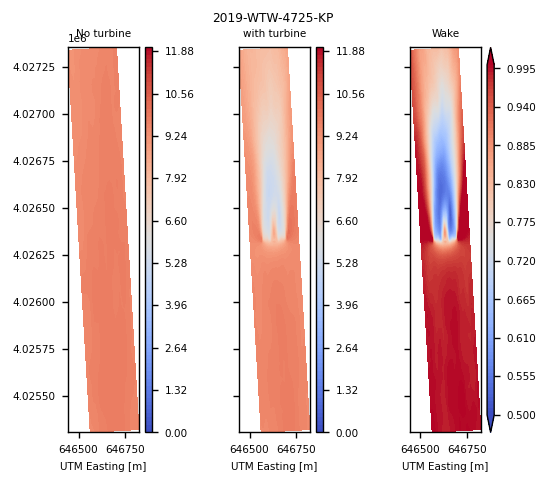

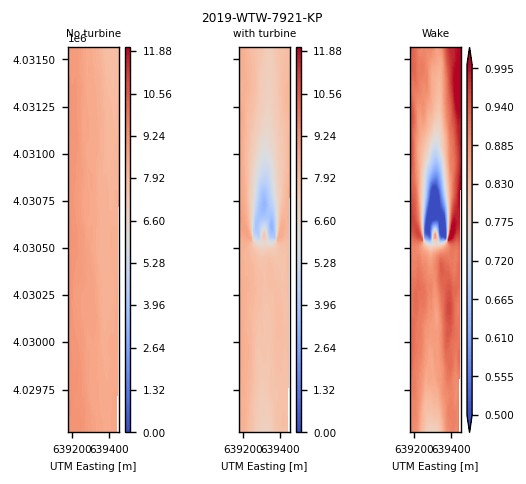

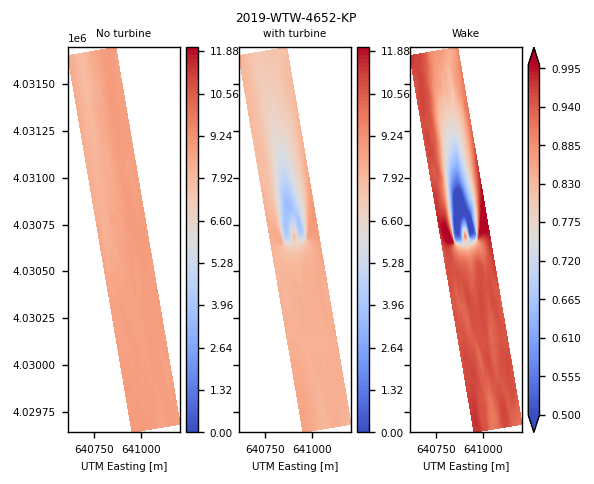

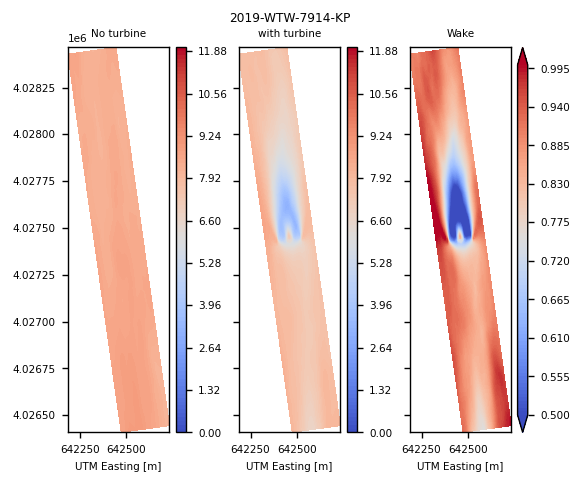

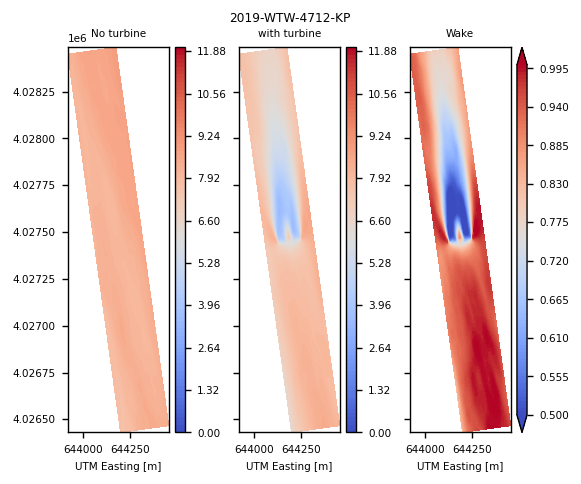

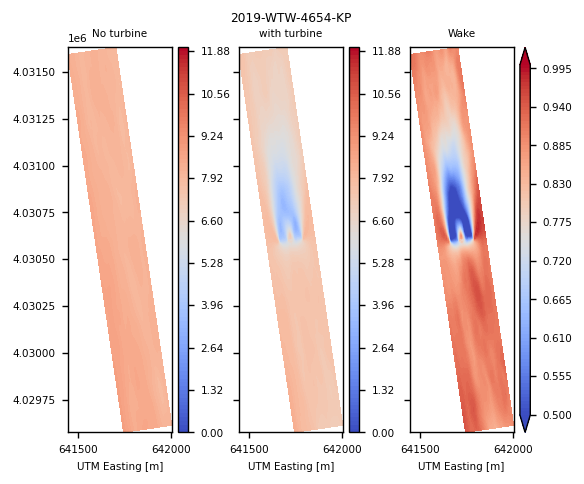

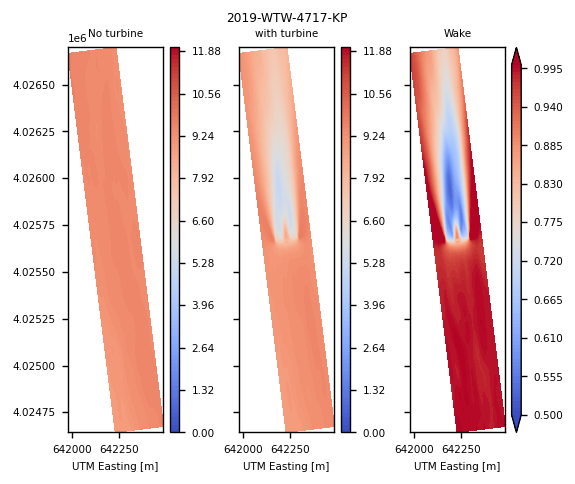

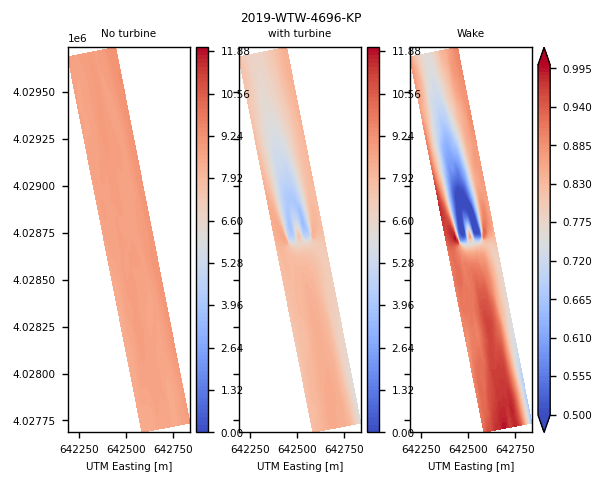

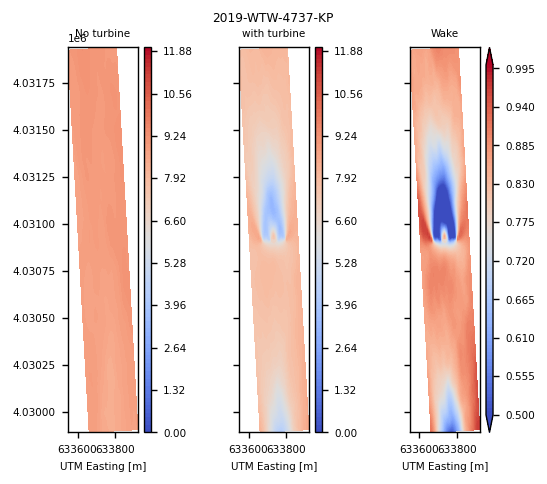

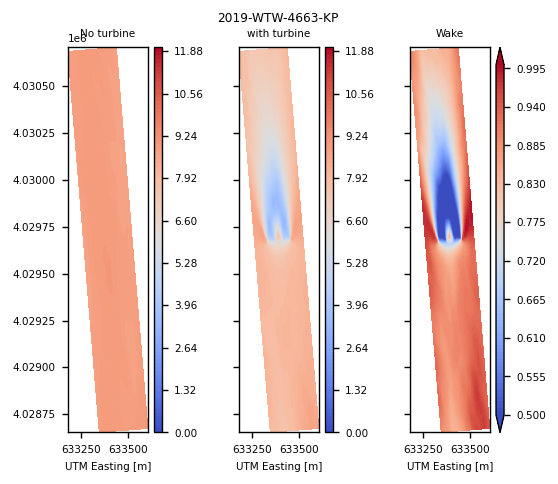

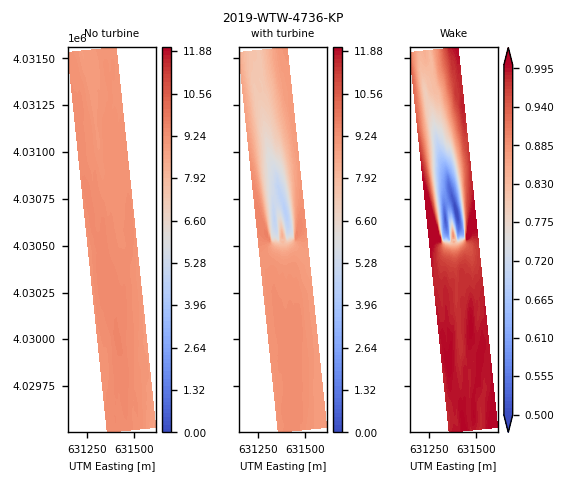

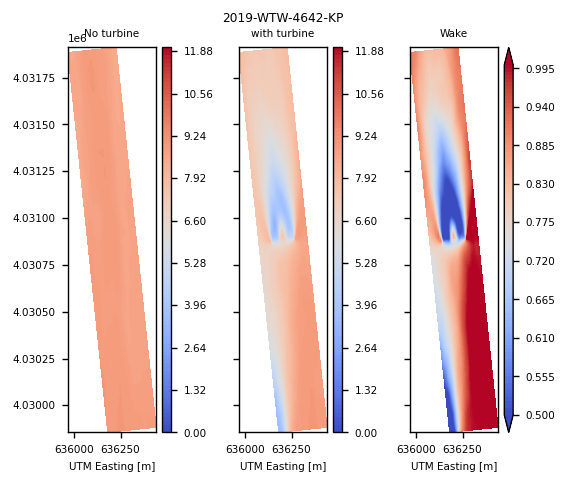

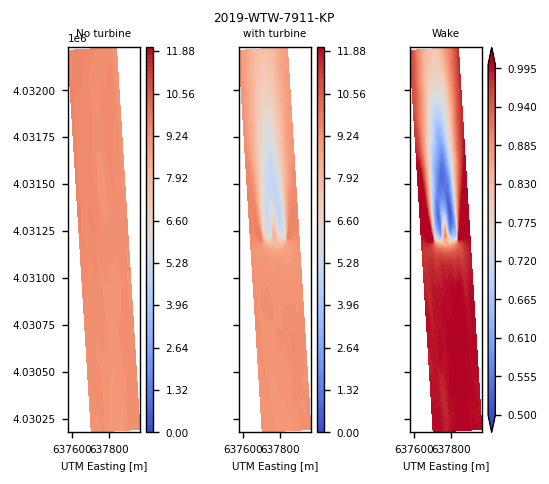

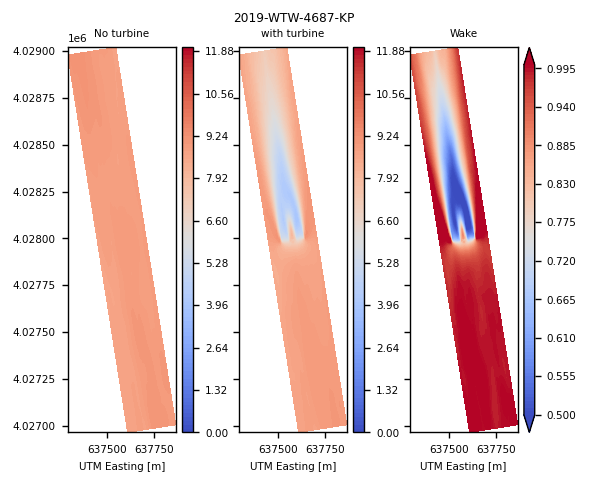

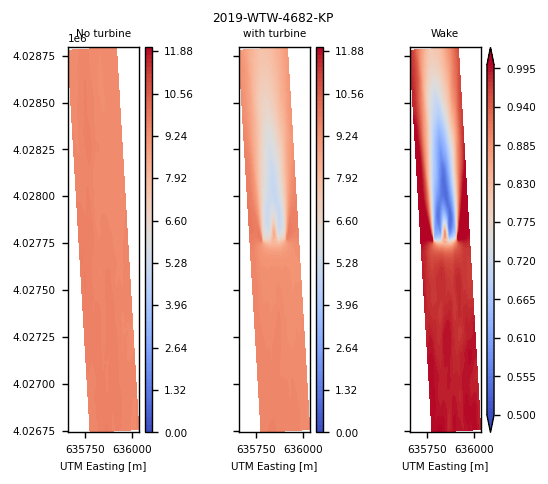

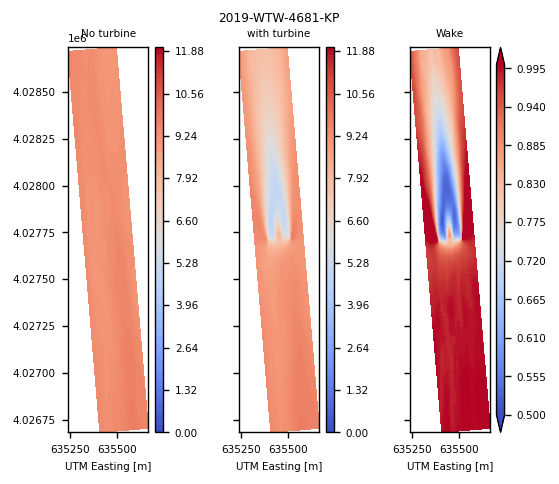

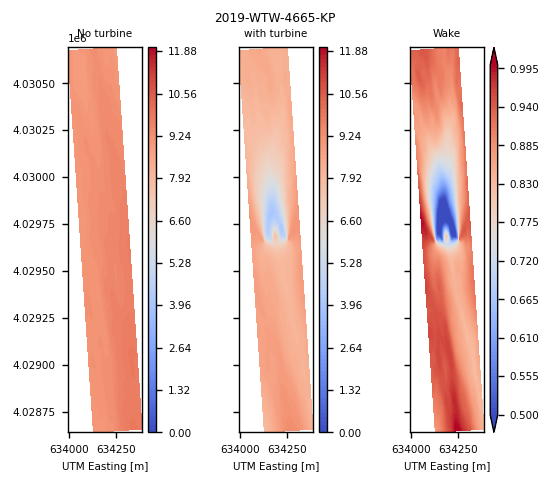

In [6]:
vlevels = np.linspace(0, 12,101)
difflevels = np.linspace(0.5, 1, 101)
fontsize = 6
resetgrid= False

for turb in allturblist[::4]:
    fig, axs = plt.subplots(1,3,figsize=(5,4), dpi=125, sharey=True)
    # Load the no turbine dir
    noturbpkl = pkldir+'/'+turbname%(turb, 'noturb')
    wturbpkl  = pkldir+'/'+turbname%(turb, 'wturb')
    x, y, z, vx, vy, vz, time = loadPickle(noturbpkl)
    vx_avg_not = avgfield(vx, tavg1, tavg2)
    vy_avg_not = avgfield(vy, tavg1, tavg2)
    
    x, y, z, vx, vy, vz, time = loadPickle(wturbpkl)
    vx_avg_wt = avgfield(vx, tavg1, tavg2)
    vy_avg_wt = avgfield(vy, tavg1, tavg2)
    
    if resetgrid:
        xm, ym = getCartesianMesh(x,y)
        scale = 127
        x0 = np.mean(xm)
        y0 = np.mean(ym)
        xp, yp = (xm-x0)/scale, (ym-y0)/scale
        xlabel = 'x/D'
    else:
        xp, yp = x,y
        xlabel = 'UTM Easting [m]'
    
    # plot the no turbine mean flow case
    ax=axs[0]
    vh_not = np.sqrt(vx_avg_not**2 + vy_avg_not**2)
    c=ax.contourf(xp, yp, vh_not[0,:,:], levels=vlevels, cmap='coolwarm')
    makecbarax(ax, c, fontsize, size='10%')
    ax.set_aspect('equal')
    ax.set_xlabel(xlabel)
    ax.set_title('No turbine')
    setfigtextsize(ax, fontsize)
    
    # plot the no turbine mean flow case
    ax=axs[1]
    vh_wt = np.sqrt(vx_avg_wt**2 + vy_avg_wt**2)
    c=ax.contourf(xp, yp, vh_wt[0,:,:], levels=vlevels, cmap='coolwarm')
    makecbarax(ax, c, fontsize, size='10%')
    ax.set_aspect('equal')
    ax.set_xlabel(xlabel)
    ax.set_title('with turbine')
    setfigtextsize(ax, fontsize)
    
    # plot the difference
    ax=axs[2]
    vh_diff = np.sqrt((vx_avg_not-vx_avg_wt)**2 + (vx_avg_not-vy_avg_wt)**2)
    c=ax.contourf(xp, yp, vh_wt[0,:,:]/vh_not[0,:,:], levels=difflevels, cmap='coolwarm', extend='both') 
    makecbarax(ax, c, fontsize, size='10%')
    ax.set_aspect('equal')
    ax.set_xlabel(xlabel)
    ax.set_title('Wake')
    setfigtextsize(ax, fontsize)
    
    fig.suptitle(turb, y=0.95, fontsize =fontsize+1) 

In [7]:
allnoturbfiles = [pkldir+'/'+turbname%(x, 'noturb') for x in allturblist]
allwturbfiles  = [pkldir+'/'+turbname%(x, 'wturb') for x in allturblist]

x,y,z, avg_vx_noturb, avg_vy_noturb, avg_vz_noturb  = avgFileList(allnoturbfiles, tavg1, tavg2)
x,y,z, avg_vx_wturb, avg_vy_wturb, avg_vz_wturb  = avgFileList(allwturbfiles, tavg1, tavg2)

xm, ym = getCartesianMesh(x,y)
scale = 127
x0 = np.mean(xm)
y0 = np.mean(ym)
xp, yp = (xm-x0)/scale, (ym-y0)/scale

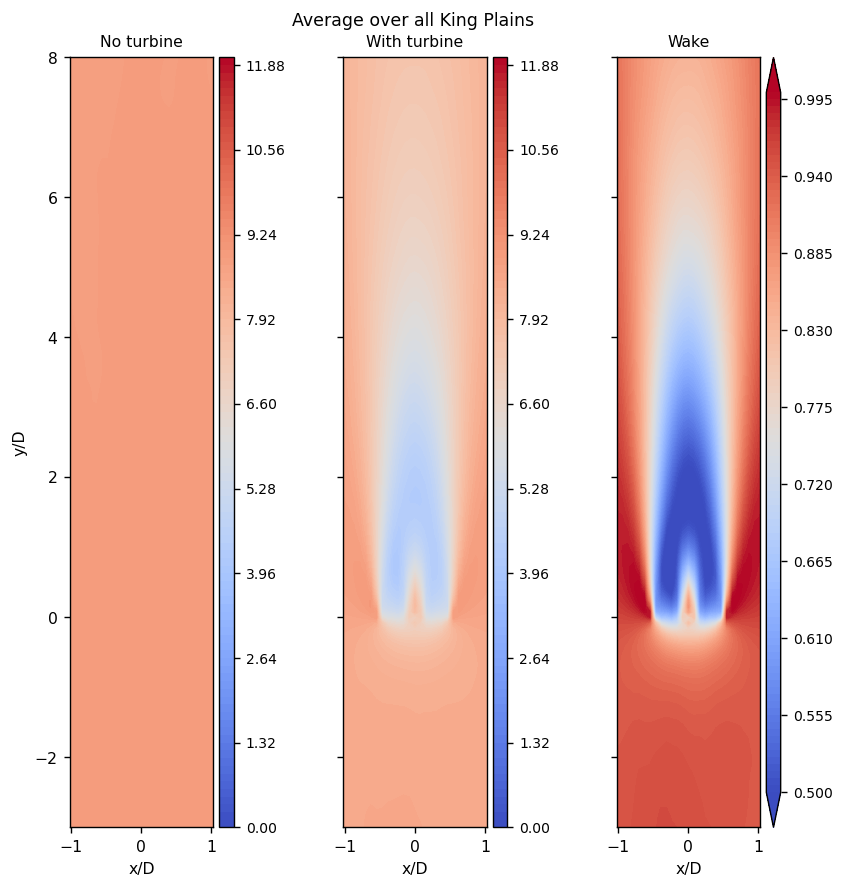

In [8]:
fontsize=9
xlabel = 'x/D'
ylabel = 'y/D'
fig, axs = plt.subplots(1,3,figsize=(8,8), dpi=125, sharey=True)

vh_not = np.sqrt(avg_vx_noturb**2 + avg_vy_noturb**2)
vh_wt = np.sqrt(avg_vx_wturb**2 + avg_vy_wturb**2)
vh_diff = np.sqrt((avg_vx_noturb-avg_vx_wturb)**2 + (avg_vy_noturb-avg_vy_wturb)**2)

ax=axs[0]
c=ax.contourf(xp, yp, vh_not[0,:,:], levels=vlevels, cmap='coolwarm')
makecbarax(ax, c, fontsize-1, size='10%')
ax.set_aspect('equal')
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_ylim([-3, 8])
ax.set_title('No turbine')
setfigtextsize(ax, fontsize)

ax=axs[1]
c=ax.contourf(xp, yp, vh_wt[0,:,:], levels=vlevels, cmap='coolwarm')
makecbarax(ax, c, fontsize-1, size='10%')
ax.set_aspect('equal')
ax.set_xlabel(xlabel)
ax.set_ylim([-3, 8])
ax.set_title('With turbine')
setfigtextsize(ax, fontsize)

ax=axs[2]
c=ax.contourf(xp, yp, vh_wt[0,:,:]/vh_not[0,:,:], levels=difflevels, cmap='coolwarm', extend='both')
makecbarax(ax, c, fontsize-1, size='10%')
ax.set_aspect('equal')
ax.set_xlabel(xlabel)
ax.set_ylim([-3, 8])
ax.set_title('Wake')
setfigtextsize(ax, fontsize)

fig.suptitle('Average over all King Plains', y=0.925, fontsize =fontsize+1);